In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(0, "../src")
from figures import figure_sizes

from pyDOE import lhs
from scipy.linalg import norm
from statfenics.utils import build_observation_operator
from swe import ShallowOne, ShallowOneLinear
from swe_filter import ShallowOneKalman, ShallowOneEx
from tqdm import tqdm

np.random.seed(28)

In [2]:
# HACK(connor): set various globals
k = 32
NX = 500
DT = 0.01
THETA = 0.6

k = 32
nt_skip = 100
sigma_y = 5e-4

# set the observation system
t_final = 200.
nt = np.int64(t_final / DT)
t_grid = np.arange(0., t_final, DT)

nx_skip = 10
dat = xr.open_dataset("../data/h_bump.nc")

# do some double checking
assert DT == dat.coords["t"].values[1] - dat.coords["t"].values[0]
# np.testing.assert_allclose(dat.coords["x"].values, swe_post.x_coords.flatten())

# build observation/interpolation operators
# y = dat["h"].values[1:, ::nx_skip]
y_obs = dat["h"].values[1:nt:nt_skip, ::nx_skip]  # dont include IC
t_obs = t_grid[1::nt_skip]

# verify things are OK
print(t_obs)
print(t_obs.shape)
print(y_obs.shape)

x_obs = dat.coords["x"].values[::nx_skip][:, np.newaxis]
nx_obs = len(x_obs)

idx = len(x_obs) // 2
obs_loc = x_obs[idx, :].reshape(1, 1)

print(f"Assimilating every {nt_skip} timesteps ({nt_skip * DT:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")

[1.0000e-02 1.0100e+00 2.0100e+00 3.0100e+00 4.0100e+00 5.0100e+00
 6.0100e+00 7.0100e+00 8.0100e+00 9.0100e+00 1.0010e+01 1.1010e+01
 1.2010e+01 1.3010e+01 1.4010e+01 1.5010e+01 1.6010e+01 1.7010e+01
 1.8010e+01 1.9010e+01 2.0010e+01 2.1010e+01 2.2010e+01 2.3010e+01
 2.4010e+01 2.5010e+01 2.6010e+01 2.7010e+01 2.8010e+01 2.9010e+01
 3.0010e+01 3.1010e+01 3.2010e+01 3.3010e+01 3.4010e+01 3.5010e+01
 3.6010e+01 3.7010e+01 3.8010e+01 3.9010e+01 4.0010e+01 4.1010e+01
 4.2010e+01 4.3010e+01 4.4010e+01 4.5010e+01 4.6010e+01 4.7010e+01
 4.8010e+01 4.9010e+01 5.0010e+01 5.1010e+01 5.2010e+01 5.3010e+01
 5.4010e+01 5.5010e+01 5.6010e+01 5.7010e+01 5.8010e+01 5.9010e+01
 6.0010e+01 6.1010e+01 6.2010e+01 6.3010e+01 6.4010e+01 6.5010e+01
 6.6010e+01 6.7010e+01 6.8010e+01 6.9010e+01 7.0010e+01 7.1010e+01
 7.2010e+01 7.3010e+01 7.4010e+01 7.5010e+01 7.6010e+01 7.7010e+01
 7.8010e+01 7.9010e+01 8.0010e+01 8.1010e+01 8.2010e+01 8.3010e+01
 8.4010e+01 8.5010e+01 8.6010e+01 8.7010e+01 8.8010e+01 8.9010

In [3]:
def estimate_energy(swe_post, swe_dummy, n_samples=100):
    mean = swe_post.mean
    L = swe_post.cov_sqrt
    k = L.shape[1]
   
    # i hate broadcasting
    samples = (mean + (L @ np.random.normal(size=(k, n_samples))).T).T
    e = np.zeros((n_samples, ))
    for i in range(n_samples):
        swe_dummy.set_curr_vector(samples[:, i])
        e[i] = swe_dummy.compute_energy()
        
    return np.mean(e), np.var(e)
    
    
def estimate_quantities(nu, c):
    # statistical parameters
    stat_params = dict(rho_u=1e-2, ell_u=5.,
                       rho_h=1, ell_h=5.,
                       k=k, k_init_u=k, k_init_h=k,
                       hilbert_gp=True)
    
    # instantiate required posterior computations
    swe = ShallowOne(
        control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
        params=dict(nu=nu, bump_centre=c))

    swe_post_ex = ShallowOneEx(
        control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
        params=dict(nu=nu, bump_centre=c),
        stat_params=stat_params,
        lr=True)
    
    # build observation operators
    H_obs = build_observation_operator(x_obs, swe_post_ex.W, sub=1, out="scipy")
    H_u_verts = build_observation_operator(swe_post_ex.x_coords, swe_post_ex.W, sub=0)
    H_h_mid = build_observation_operator(obs_loc, swe_post_ex.W, sub=1)
    print(H_h_mid.shape)

    # build obs. operator
    nt_obs = len([i for i in range(nt) if i % nt_skip == 0])
    print(nt_obs)

    energy_mean = np.zeros((nt, ))
    energy_var = np.zeros((nt, ))
    sqrt_norm = np.zeros((nt, ))

    h_mid_mean = np.zeros((nt, ))
    h_mid_var = np.zeros((nt, ))

    t = 0.
    i_save = 0
    for i in tqdm(range(nt)):
        t += swe_post_ex.dt
        swe_post_ex.prediction_step(t)

        if i % nt_skip == 0:
            swe_post_ex.update_step(y_obs[i_save, :], H_obs, sigma_y)
            i_save += 1

        # estimate midpoint
        h_mid_mean[i] = (H_h_mid @ swe_post_ex.mean)[0]
        h_mid_var[i] = np.sum((H_h_mid @ swe_post_ex.cov_sqrt)**2, axis=1)[0]
        
        # estimate energy
        energy_mean[i], energy_var[i] = estimate_energy(swe_post_ex, swe)
        
        # estimate covariance_norm
        sqrt_norm[i] = norm(H_u_verts @ swe_post_ex.cov_sqrt, ord=2)

        swe_post_ex.set_prev()
        
    return (sqrt_norm, h_mid_mean, h_mid_var, energy_mean, energy_var, )

In [ ]:
from multiprocessing import Pool
p = Pool(4)
out = p.starmap(estimate_quantities,
                [(1e-3, 5.), (1e-4, 10.), (1e-3, 15.), (1e-3, 20.)])





(1, 1502)
200


  0%|                                                                                                                         | 0/20000 [00:00<?, ?it/s]

(1, 1502)
200


  0%|                                                                                                                         | 0/20000 [00:00<?, ?it/s]

(1, 1502)
200(1, 1502)



  0%|                                                                                                                         | 0/20000 [00:00<?, ?it/s]

200


 15%|████████████████▊                                                                                             | 3055/20000 [02:36<14:46, 19.12it/s]

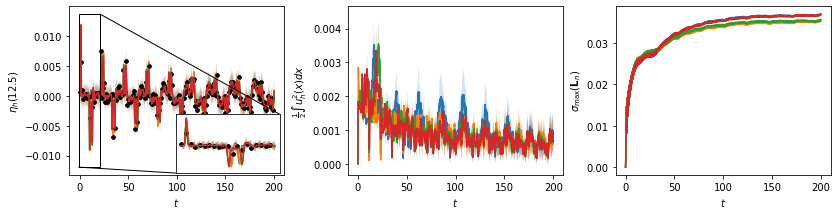

In [21]:
from figures import figure_sizes
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                        figsize=(1.6 * figure_sizes["fullwidth"], 0.4 * figure_sizes["fullwidth"]))
axins = axs[0].inset_axes([0.5, 0.01, 0.48, 0.35])
axins.set_xticks([])
axins.set_yticks([])
axins.set_xticklabels('')
axins.set_yticklabels('')

for i in range(len(out)):
    sqrt_norm, h_mid_mean, h_mid_var, energy_mean, energy_var = out[i]
    axs[0].plot(t_obs, y_obs[:, idx], ".", color="black")
    axs[0].plot(t_grid, h_mid_mean)
    axs[0].fill_between(t_grid, 
                        h_mid_mean - 1.96 * np.sqrt(h_mid_var),
                        h_mid_mean + 1.96 * np.sqrt(h_mid_var),
                        alpha=0.2)
    
    axins.plot(t_obs[:20], y_obs[:20, idx], ".", color="black")
    axins.plot(t_grid[:2000], h_mid_mean[:2000])
    axins.fill_between(t_grid[:2000], 
                       h_mid_mean[:2000] - 1.96 * np.sqrt(h_mid_var[:2000]),
                       h_mid_mean[:2000] + 1.96 * np.sqrt(h_mid_var[:2000]),
                       alpha=0.2)

    axs[1].plot(t_grid, energy_mean)
    axs[1].fill_between(t_grid, 
                     energy_mean - 1.96 * np.sqrt(energy_var),
                     energy_mean + 1.96 * np.sqrt(energy_var),
                     alpha=0.2)

    axs[2].plot(t_grid, sqrt_norm)
    
# cleaning up plot aesthetics
for ax in axs:
    ax.set_xlabel(r"$t$")

axs[0].indicate_inset_zoom(axins, alpha=1., edgecolor="black")
axs[0].set_ylabel(r"$\eta_h(12.5)$")
axs[1].set_ylabel(r"$\frac{1}{2} \int u_h^2(x) dx$")
axs[2].set_ylabel(r"$\sigma_{\mathrm{max}}(\mathbf{L}_n)$")
plt.savefig("../figures/posterior-comparison-quantities.pdf")